In [27]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point


# Difference calculation

In [62]:


# 定义区域和时间点
regions = ['Camden', 'City of London', 'Islington', 'Kensington and Chelsea', 'Lambeth', 'Southwark', 'Westminster']
# time_points = {
#     "2019 Central Zone": pd.to_datetime("2019-04-08"),
#     "2020 Covid-19 Lockdown": pd.to_datetime("2020-01-01"),
#     "2021 Lockdown release": pd.to_datetime("2021-02-22"),
#     "2021 Inner Expansion": pd.to_datetime("2021-10-25"),
#     "2023 Outer Expansion": pd.to_datetime("2023-08-29")
# }

# Ensure time_points only contain dates (not times)
time_points = {
    "2019 Central Zone": pd.to_datetime("2019-04-08").date(),
    "2020 Covid-19 Lockdown": pd.to_datetime("2020-01-01").date(),
    "2021 Lockdown release": pd.to_datetime("2021-02-22").date(),
    "2021 Inner Expansion": pd.to_datetime("2021-10-25").date(),
    "2023 Outer Expansion": pd.to_datetime("2023-08-29").date()
}

# Adjust time_periods to match the date-only format
# Ensure time_periods contains datetime.date objects
time_periods = {
    "pre2019ULEZ": (pd.to_datetime("2015-01-01").date(), pd.to_datetime("2019-04-07").date()),
    "post2019ULEZ_pre2021ULEZ": (pd.to_datetime("2019-04-08").date(), pd.to_datetime("2021-10-24").date()),
    "post2021ULEZ_pre2023ULEZ": (pd.to_datetime("2021-10-25").date(), pd.to_datetime("2023-08-28").date()),
    "post2023ULEZ": (pd.to_datetime("2023-08-29").date(), None)
}

# 读取传感器坐标数据
coords_path = "D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data\\AirQuality\\LondonAir\\coords_sensor.csv"
coords_df = pd.read_csv(coords_path)

# 定义气体种类
species_files = {
    "NO": "Nitric Oxide (ug m-3).csv",
    "NO2": "Nitrogen Dioxide (ug m-3).csv",
    "PM2.5": "PM2.5 Particulates (reference equivalent).csv",
    "PM10": "PM10 Particulates (reference equivalent).csv"
}

# 创建结果数据框
results = {species: [] for species in species_files.keys()}


breathe_folder="D:\File_auto\0_UCL_CASA\OneDrive - University College London\Xiaoyi_dissertation\Analysis\Data\AirQuality\BreatheLondon2\\"

<>:45: SyntaxWarning: invalid escape sequence '\F'
<>:45: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\1234884728.py:45: SyntaxWarning: invalid escape sequence '\F'
  breathe_folder="D:\File_auto\0_UCL_CASA\OneDrive - University College London\Xiaoyi_dissertation\Analysis\Data\AirQuality\BreatheLondon2\\"


In [63]:

# 遍历每个区域和气体种类
for region in regions:
    for species, file_suffix in species_files.items():
        file_path = f"D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data\\AirQuality\\LondonAir\\{region}\\{region}-{file_suffix}"
        df = pd.read_csv(file_path)
        
        # 转换日期时间格式并去掉时间部分
        df["ReadingDateTime"] = pd.to_datetime(df["ReadingDateTime"], format="%d/%m/%Y %H:%M").dt.date
        
        # 计算每个时间段的平均值
        mean_values = {}
        for period, (start, end) in time_periods.items():
            if isinstance(start, list):  # 处理多个时间段
                period_df = pd.concat([df[(df["ReadingDateTime"] > s) & (df["ReadingDateTime"] <= e)] for s, e in start])
            else:
                period_df = df[(df["ReadingDateTime"] > start) & (df["ReadingDateTime"] <= end)] if start else df[df["ReadingDateTime"] <= end]
            mean_values[period] = period_df["Value"].mean()


       # 检查2021年之后的数据是否有缺失
        if df[df["ReadingDateTime"] > pd.to_datetime('2021-01-27').date()]['Value'].isnull().values.any():
            breathe_region_folder = os.path.join(breathe_folder, region)  # 替换为实际BreatheLondon2数据文件夹路径
            breathe_files = [f for f in os.listdir(breathe_region_folder) if f.endswith(f'_{species}.csv')]
            
            for file in breathe_files:
                try:
                    breathe_df = pd.read_csv(os.path.join(breathe_region_folder, file))
                    
                    # 统一日期格式
                    breathe_df['ReadingDateTime'] = pd.to_datetime(breathe_df['Date'], format='%Y-%m-%d')
                    breathe_df.rename(columns={f'{species}_mean': 'Value'}, inplace=True)
                    
                    # 提取坐标信息
                    coords_breathe_path = os.path.join("path_to_breathe_folder", 'coords_breathelondon.csv')
                    coords_breathe_df = pd.read_csv(coords_breathe_path)
                    coords_breathe_df[['Latitude', 'Longitude']] = coords_breathe_df['Latitude & Longitude'].str.split(', ', expand=True).astype(float)
                    
                    # 合并坐标信息
                    breathe_df = pd.merge(breathe_df, coords_breathe_df[['Site', 'Latitude', 'Longitude']], on='Site', how='left')
                    
                    # 合并数据
                    df = pd.concat([df, breathe_df[['ReadingDateTime', 'Site', 'Value', 'Latitude', 'Longitude']]], ignore_index=True)
                
                except ValueError as e:
                    print(f"Error processing file {file}: {e}")
                except Exception as e:
                    print(f"Unexpected error processing file {file}: {e}")
        



        # 计算百分比变化
        percentage_changes = {
            "post2019": (mean_values["post2019ULEZ_pre2021ULEZ"] - mean_values["pre2019ULEZ"]) * 100 / mean_values["pre2019ULEZ"],
            "post2021": (mean_values["post2021ULEZ_pre2023ULEZ"] - mean_values["pre2019ULEZ"]) * 100 / mean_values["pre2019ULEZ"],
            "post2023": (mean_values["post2023ULEZ"] - mean_values["pre2019ULEZ"]) * 100 / mean_values["pre2019ULEZ"]
        }
        
        # 获取传感器信息
        sensor_info = coords_df[coords_df["Site"].isin(df["Site"].unique())]
        
        # 生成结果数据
        for period, change in percentage_changes.items():
            for site in sensor_info["Site"].unique():
                site_info = sensor_info[sensor_info["Site"] == site].iloc[0]
                results[species].append({
                    "Site": site,
                    "ULEZ_period": period,
                    "Percentage_Change": change,
                    "Mean_Value": mean_values.get(f"post{period.split('post')[1]}ULEZ_pre2021ULEZ", None),
                    "Classification": site_info["Classification"],
                    "Latitude & Longitude": site_info["Latitude & Longitude"]
                })

# 保存结果到CSV文件
output_dir = "D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data_output\\Difference\\"
os.makedirs(output_dir, exist_ok=True)
for species, data in results.items():
    output_path = os.path.join(output_dir, f"{species}_diff.csv")
    pd.DataFrame(data).to_csv(output_path, index=False)

ValueError: listdir: embedded null character in path

# Plot

In [36]:
# 读取Shapefile文件
lon_msoa = gpd.read_file('D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data\london_boundaries\statistical-gis-boundaries-london\statistical-gis-boundaries-london\ESRI\MSOA_2011_London_gen_MHW.shp')

# 筛选指定的boroughs
selected_boroughs = lon_msoa[lon_msoa['LAD11NM'].isin(['City of London', 'Islington', 'Kensington and Chelsea', 'Westminster', 'Camden', 'Lambeth', 'Southwark'])]


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\230533500.py:2: SyntaxWarning: invalid escape sequence '\l'
  lon_msoa = gpd.read_file('D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data\london_boundaries\statistical-gis-boundaries-london\statistical-gis-boundaries-london\ESRI\MSOA_2011_London_gen_MHW.shp')


In [31]:
# selected_boroughs.head()
print(selected_boroughs.crs)

PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601272],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [52]:

# 定义输出目录和物种列表
output_dir = "D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data_output\\Difference\\"
species_list = ["NO", "NO2", "PM2.5", "PM10"]  # 替换为实际物种列表
ulez_periods = ["post2019", "post2021", "post2023"]  # 替换为实际ULEZ时期列表

# 定义物种全称
species_full_names = {
    "NO": "Nitric Oxide (NO)",
    "NO2": "Nitrogen Dioxide (NO2)",
    "PM10": "PM10",
    "PM2.5": "PM2.5"
}

In [53]:
# 遍历每个物种和每个ULEZ时期
for species in species_list:
    csv_file = os.path.join(output_dir, f"{species}_diff.csv")
    if os.path.exists(csv_file):
        # 读取CSV文件
        df = pd.read_csv(csv_file)
        
        # 去掉“Latitude & Longitude”列中的引号
        df['Latitude & Longitude'] = df['Latitude & Longitude'].str.replace('"', '')
        
        # 分割“Latitude & Longitude”列
        df[['Latitude', 'Longitude']] = df['Latitude & Longitude'].str.split(', ', expand=True).astype(float)
        
        for period in ulez_periods:
            # 根据ULEZ_period过滤数据
            period_df = df[df['ULEZ_period'] == period]
            
            # 转换为GeoDataFrame
            geometry = [Point(xy) for xy in zip(period_df['Longitude'], period_df['Latitude'])]
            gdf = gpd.GeoDataFrame(period_df, geometry=geometry, crs="EPSG:4326")
            
            # 将GeoDataFrame的坐标系从WGS84转换为OSGB36
            gdf = gdf.to_crs("EPSG:27700")
            
            # 绘制图像
            fig, ax = plt.subplots(1, 1, figsize=(15, 10))
            selected_boroughs.boundary.plot(ax=ax, edgecolor='black')  # 只显示轮廓
            cmap = plt.cm.get_cmap('viridis_r')  # 反转颜色映射
            gdf.plot(ax=ax, markersize=gdf['Percentage_Change'].abs() * 10, c=gdf['Percentage_Change'], cmap=cmap, legend=True)
            
            # 设置标题
            plt.title(f"Post {period[-4:]} ULEZ Percentage Change for {species_full_names[species]}")
            
            # 保存图像
            plt.savefig(f"Post_{period[-4:]}_ULEZ_Percentage_Change_for_{species_full_names[species].replace(' ', '_').replace('(', '').replace(')', '')}.png")
            plt.close(fig)
    else:
        print(f"File {csv_file} does not exist.")

C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\2253033625.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')  # 反转颜色映射
C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\2253033625.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')  # 反转颜色映射
C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\2253033625.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')  # 反转

C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\3270900831.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')


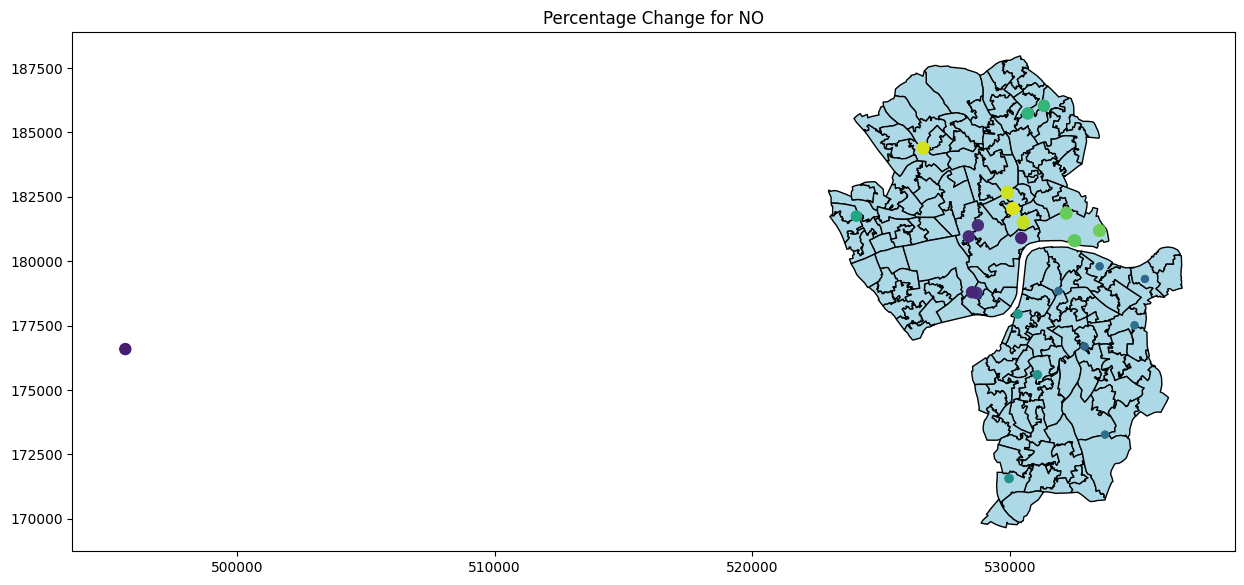

C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\3270900831.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')


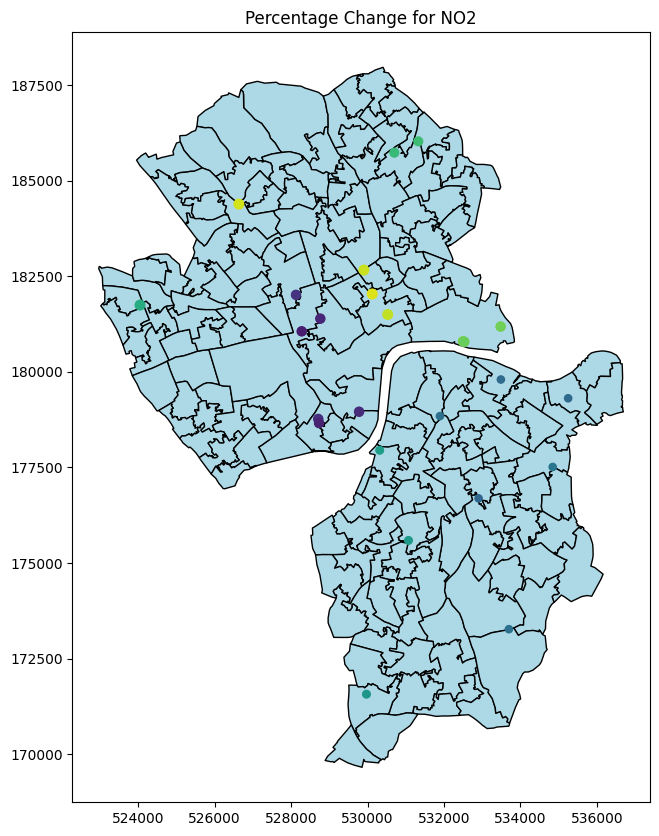

C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\3270900831.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')


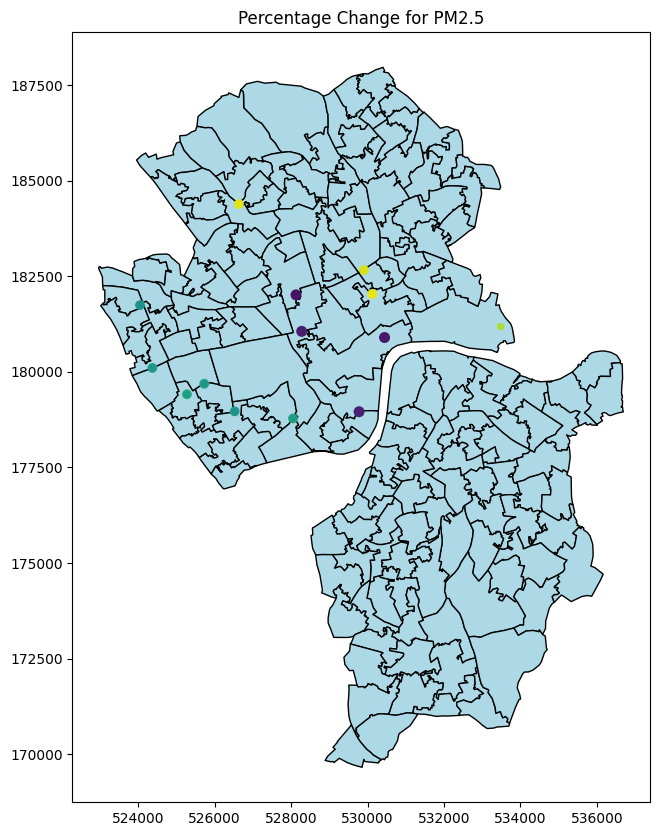

C:\Users\Chailee\AppData\Local\Temp\ipykernel_10792\3270900831.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis_r')


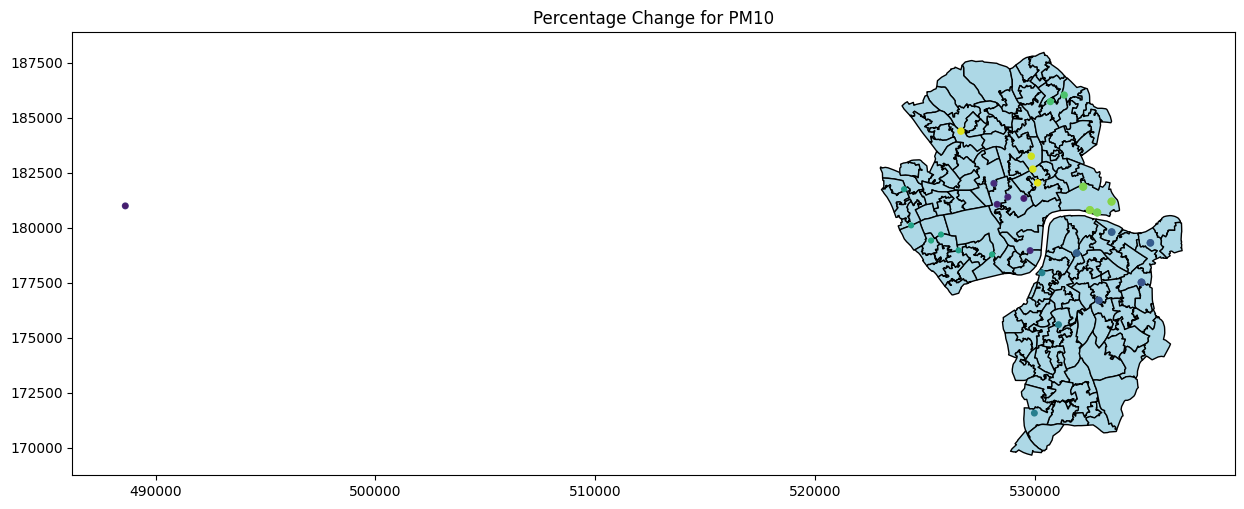

In [47]:

# 遍历每个物种
for species in species_list:
    csv_file = os.path.join(output_dir, f"{species}_diff.csv")
    if os.path.exists(csv_file):
        # 读取CSV文件
        df = pd.read_csv(csv_file)
        
        # 去掉“Latitude & Longitude”列中的引号
        df['Latitude & Longitude'] = df['Latitude & Longitude'].str.replace('"', '')
        
        # 分割“Latitude & Longitude”列并转换为GeoDataFrame
        df[['Latitude', 'Longitude']] = df['Latitude & Longitude'].str.split(', ', expand=True).astype(float)
        geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
        gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
        
        # 将GeoDataFrame的坐标系从WGS84转换为OSGB36
        gdf = gdf.to_crs("EPSG:27700")
        
        # 绘制图像
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
        selected_boroughs.plot(ax=ax, color='lightblue', edgecolor='black')
        
        # 反转颜色映射
        cmap = plt.cm.get_cmap('viridis_r')
        
        gdf.plot(ax=ax, markersize=gdf['Percentage_Change'].abs(), c=abs(gdf['Percentage_Change'])*20, cmap=cmap, legend=True)
        
        plt.title(f"Percentage Change for {species}")
        plt.show()
    else:
        print(f"File {csv_file} does not exist.")

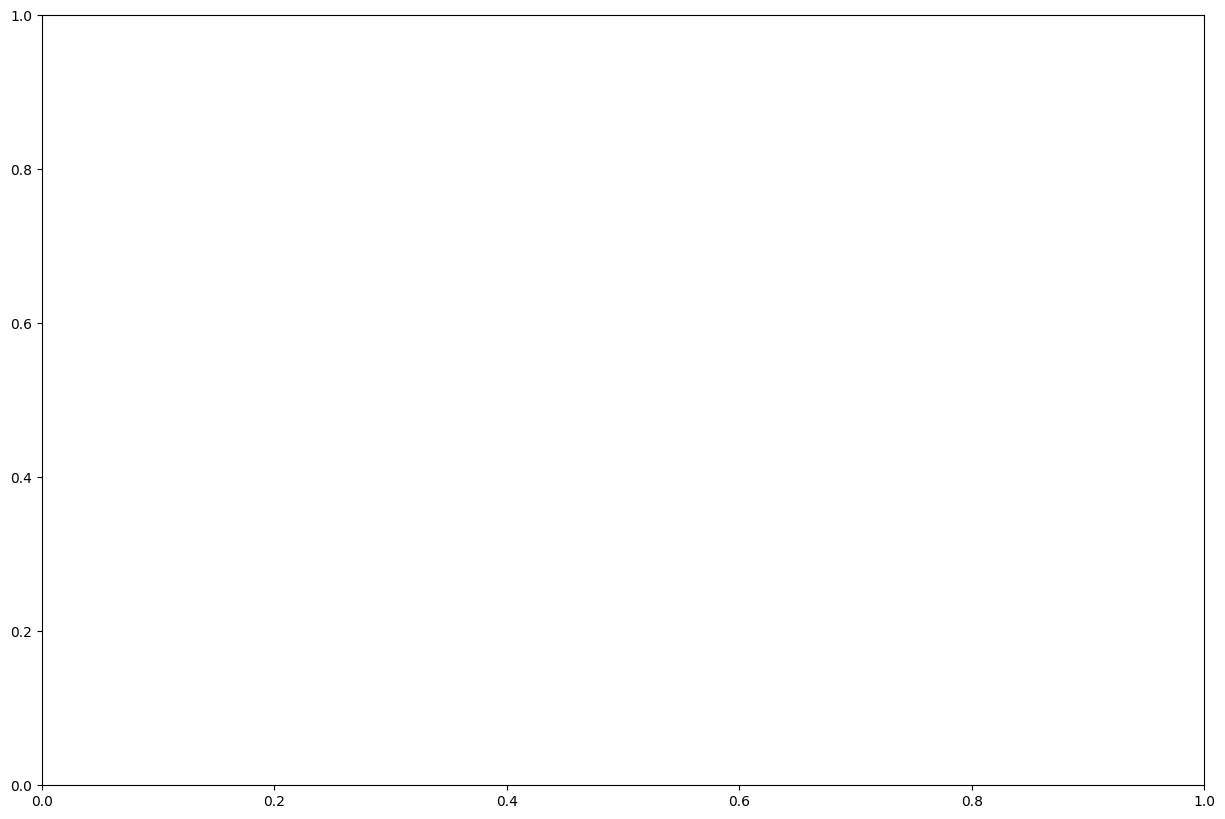

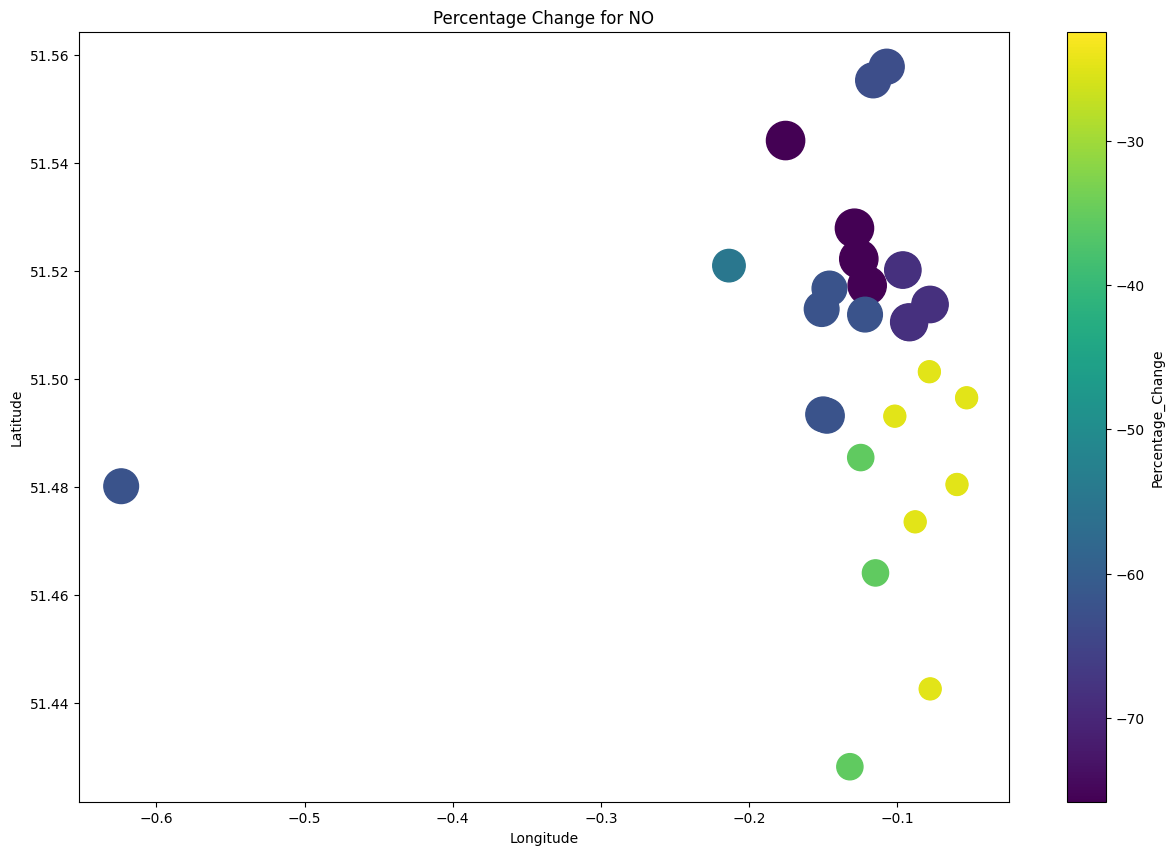

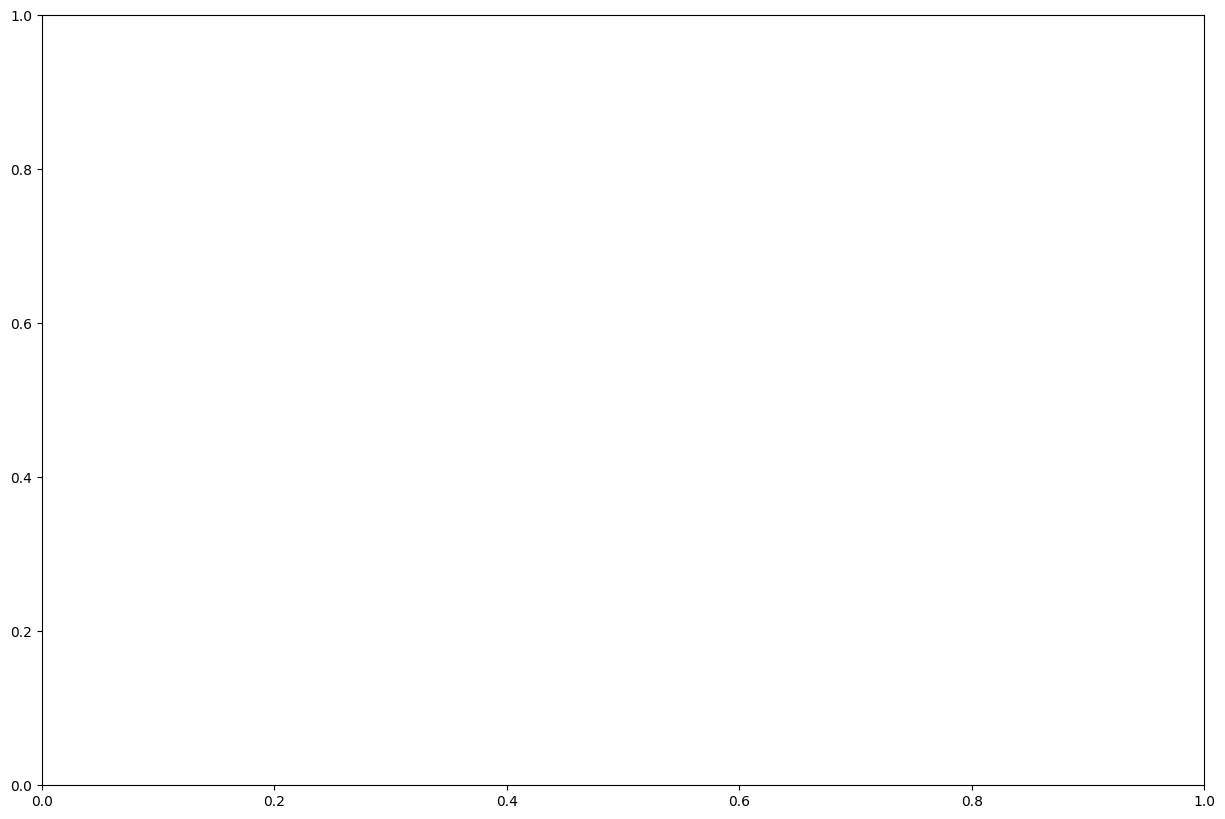

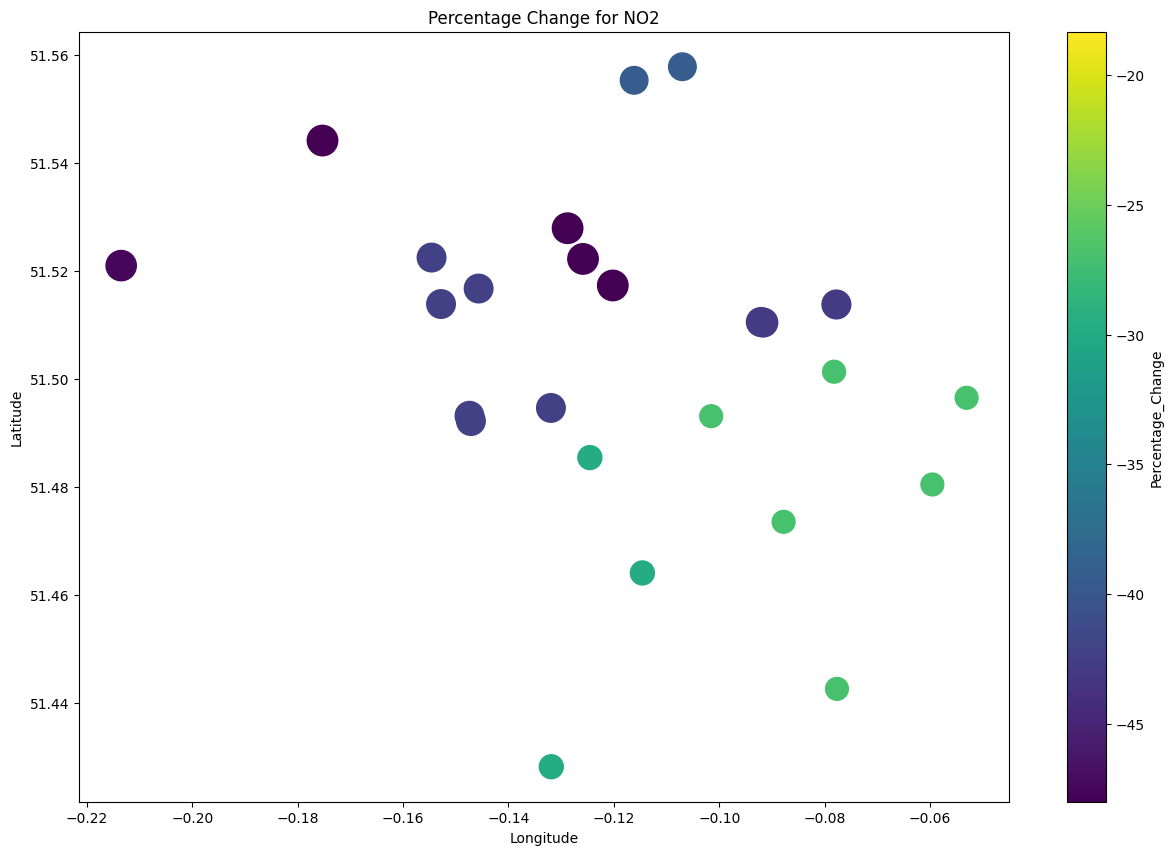

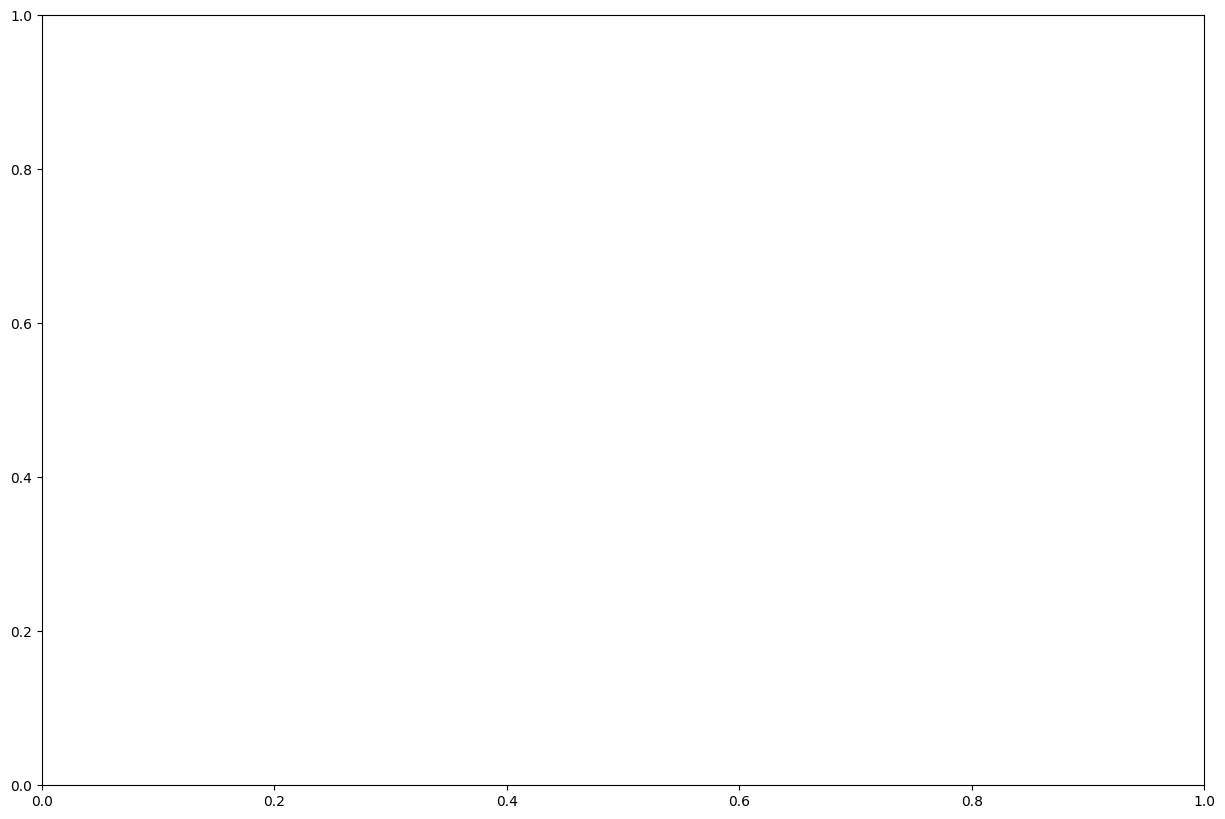

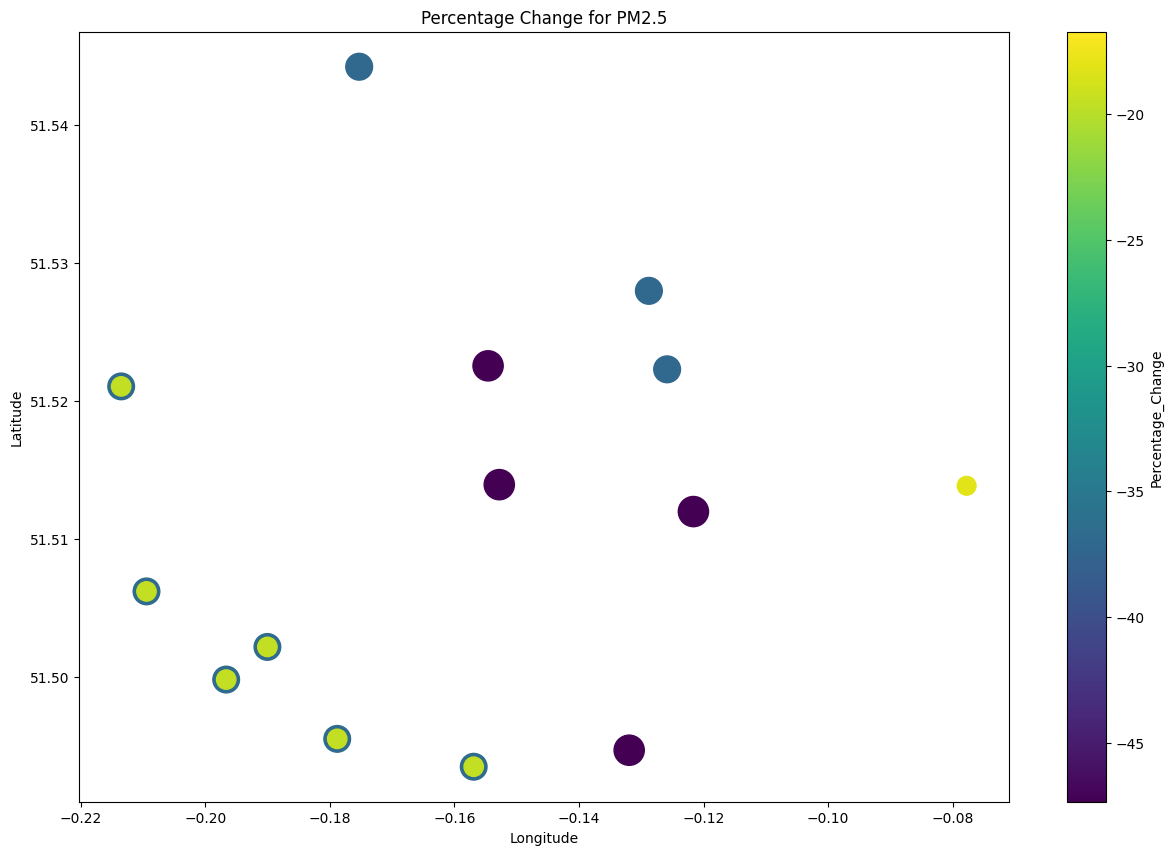

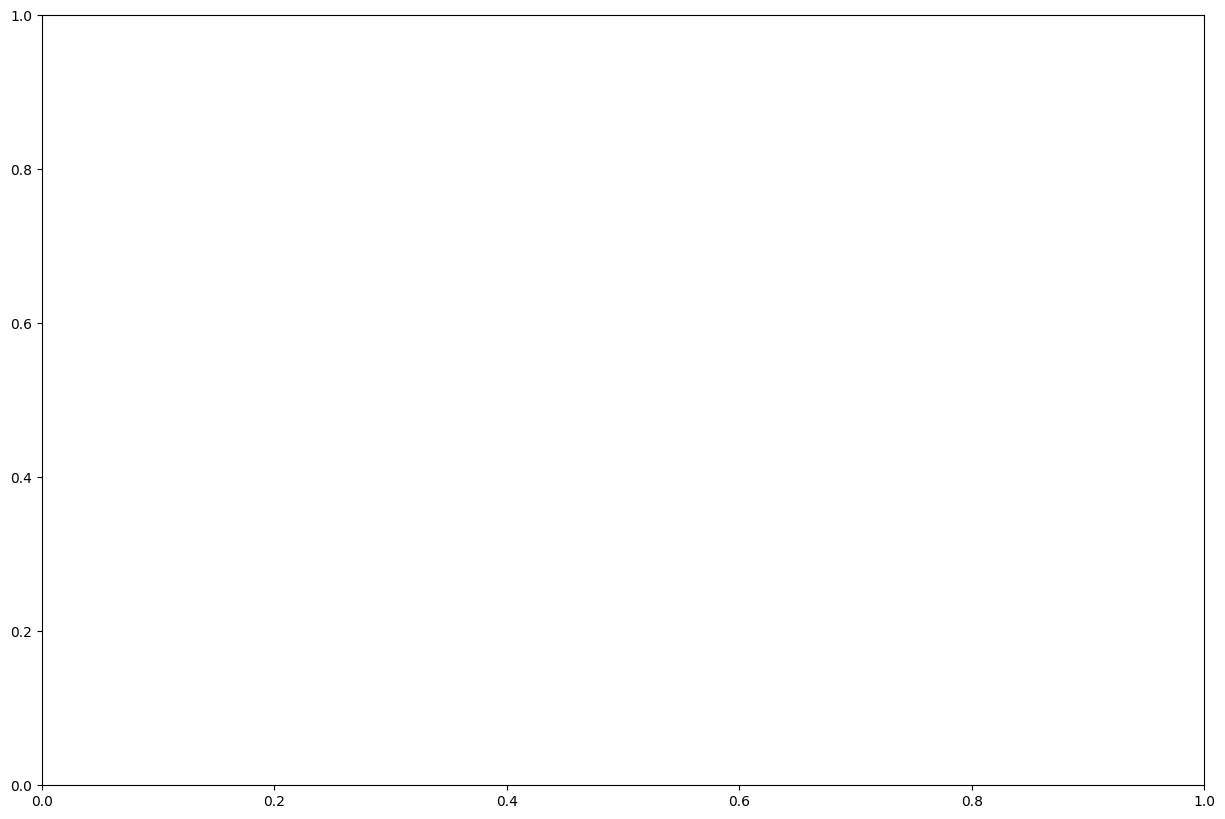

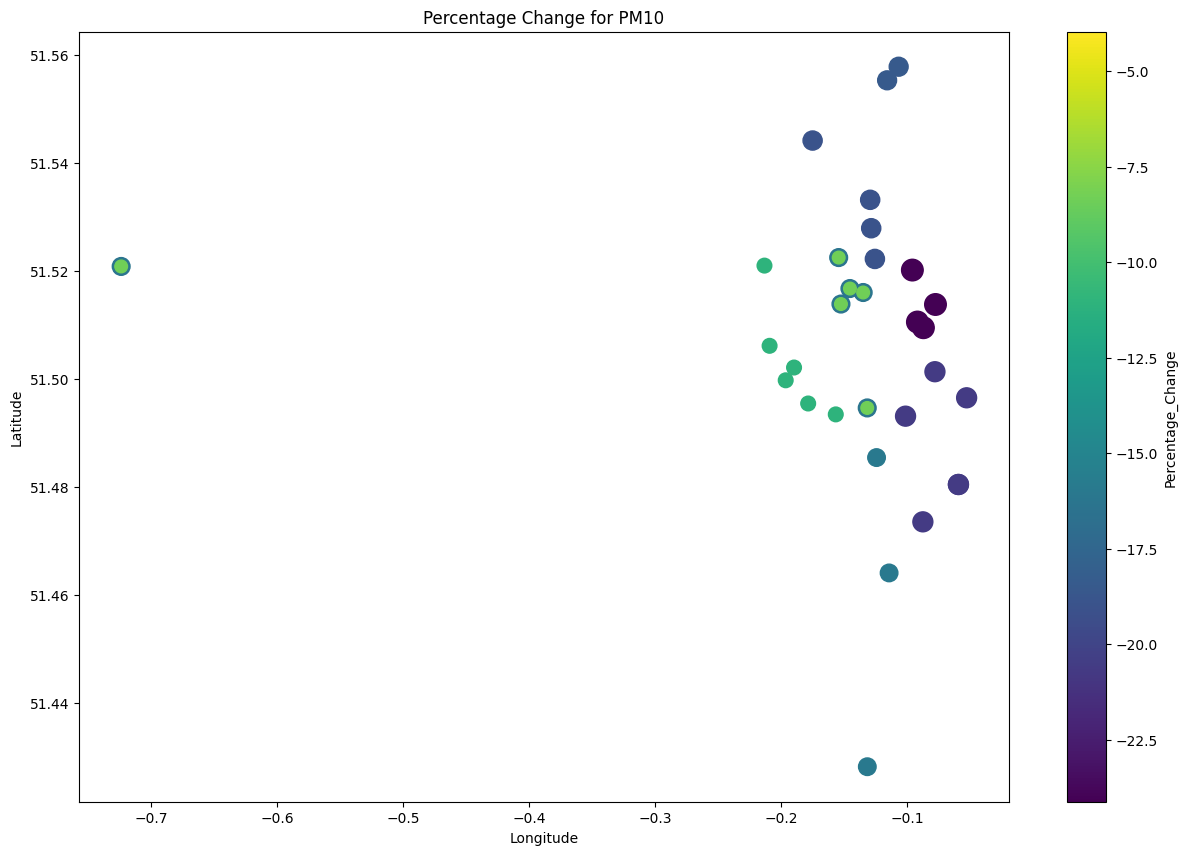

In [42]:

# # 遍历每个物种
# for species in species_list:
#     csv_file = os.path.join(output_dir, f"{species}_diff.csv")
#     if os.path.exists(csv_file):
#         # 读取CSV文件
#         df = pd.read_csv(csv_file)

#         # 去掉“Latitude & Longitude”列中的引号
#         df['Latitude & Longitude'] = df['Latitude & Longitude'].str.replace('"', '')
        
#         # 分割“Latitude & Longitude”列并转换为GeoDataFrame
#         df[['Latitude', 'Longitude']] = df['Latitude & Longitude'].str.split(', ', expand=True).astype(float)
#         geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
#         gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
        
#         # 将GeoDataFrame的坐标系从WGS84转换为OSGB36
#         gdf = gdf.to_crs("EPSG:27700")
        
#         # 绘制图像
#         fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#         # selected_boroughs.plot(ax=ax, color='lightblue', edgecolor='black')
#         # gdf.plot(ax=ax, markersize=gdf['Percentage_Change'], c=gdf['Percentage_Change'], cmap='viridis', legend=True)
#         df.plot.scatter(x='Longitude', y='Latitude', c='Percentage_Change', s=abs(df.Percentage_Change)*10, cmap='viridis', figsize=(15,10))
#         plt.title(f"Percentage Change for {species}")
#         plt.show()
#     else:
#         print(f"File {csv_file} does not exist.")

In [ ]:

# # 定义输出目录和物种列表
# output_dir = "D:\\File_auto\\0_UCL_CASA\\OneDrive - University College London\\Xiaoyi_dissertation\\Analysis\\Data_output\\Difference\\"
# species_list = ["NO", "NO2", "PM2.5", "PM10"]  # 替换为实际物种列表

# # 遍历每个物种
# for species in species_list:
#     csv_file = os.path.join(output_dir, f"{species}_diff.csv")
#     if os.path.exists(csv_file):
#         # 读取CSV文件
#         df = pd.read_csv(csv_file)
        
#         # 分割“Latitude & Longitude”列并转换为GeoDataFrame
#         df[['Latitude', 'Longitude']] = df['Latitude & Longitude'].str.split(', ', expand=True).astype(float)
#         geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
#         gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
        
#         # 绘制图像
#         fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#         selected_boroughs.plot(ax=ax, color='lightblue', edgecolor='black')
#         gdf.plot(ax=ax, markersize=gdf['Percentage_Change'], c=abs(gdf['Percentage_Change'])*10, cmap='viridis', legend=True)
        
#         plt.title(f"Percentage Change for {species}")
#         plt.show()
#     else:
#         print(f"File {csv_file} does not exist.")